# Kaggle : Predict realty prices Sberbank Russian housing market
Predict realty prices with housing data and macroeconomic patterns.

https://www.kaggle.com/c/sberbank-russian-housing-market

# 1) Data Cleaning

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
import datetime

import warnings
warnings.filterwarnings('ignore')

/Users/comalada/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [581]:
#macro_cols = ["timestamp", "balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
#"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
#"income_per_cap", "rent_price_4+room_bus"]
macro_cols = ["timestamp", "eurrub", "micex_rgbi_tr", "micex_cbi_tr"]

df_train = pd.read_csv('./train.csv')
df_macro = pd.read_csv('./macro.csv', usecols= macro_cols)
df_test = pd.read_csv('./test.csv')

In [582]:
print("Train : ")
print(df_train.shape[0])
print(df_train.shape[1])

print("Macro : ")
print(df_macro.shape[0])
print(df_macro.shape[1])

print("Test : ")
print(df_test.shape[0])
print(df_test.shape[1])

Train : 
30471
292
Macro : 
2484
4
Test : 
7662
291


## Merge Macro

In [583]:
df_train = pd.merge_ordered(df_train, df_macro, on='timestamp', how='left')
df_test = pd.merge_ordered(df_test, df_macro, on='timestamp', how='left')

# Select Columns with Null values
.isnull().any() 1) it return True if a value is Null in a column 2) .any() return True when atleast one of the elements is True.

In [584]:
null_columns = df_train.isnull().any()
df_train_null = df_train.loc[:,null_columns]

## Count null values

In [585]:
null_counts = df_train_null.isnull().sum().sort_values(ascending=False)
print(null_counts / df_train.shape[0])

hospital_beds_raion                     0.474
build_year                              0.446
state                                   0.445
cafe_sum_500_min_price_avg              0.436
cafe_sum_500_max_price_avg              0.436
cafe_avg_price_500                      0.436
max_floor                               0.314
material                                0.314
num_room                                0.314
kitch_sq                                0.314
preschool_quota                         0.219
school_quota                            0.219
cafe_sum_1000_max_price_avg             0.214
cafe_sum_1000_min_price_avg             0.214
cafe_avg_price_1000                     0.214
life_sq                                 0.209
build_count_before_1920                 0.164
build_count_block                       0.164
raion_build_count_with_material_info    0.164
build_count_wood                        0.164
build_count_frame                       0.164
build_count_brick                 

## Drop columns with too many Missing Values
Delete Columns with more or equal 20% of Missing Values

percentage_null = null_counts / df_train.shape[0]
useless_cols = []
for index, el in enumerate(percentage_null):
    if el >= 0.20:
        useless_cols.append(percentage_null.index[index])


df_train.drop(useless_cols, axis = 1, inplace = True)

print("Number of Columns Deleted Train: " + str(len(useless_cols)))

##### Test File
null_columns = df_test.isnull().any()
df_test_null = df_test.loc[:,null_columns]

null_counts = df_test_null.isnull().sum()
percentage_null = null_counts / df_test.shape[0]
useless_cols = []
for index, el in enumerate(percentage_null):
    if el >= 0.20:
        useless_cols.append(percentage_null.index[index])


df_test.drop(useless_cols, axis = 1, inplace = True)

print("Number of Columns Deleted Test: " + str(len(useless_cols)))

## Remove single columns value

In [586]:
drop_columns = []

for col in df_train.columns:
    # unique also counts the Pandas missing value object nan as a value, we then should use dropna before
    length = len(df_train[col].dropna().unique())
    
    if length == 1:
        drop_columns.append(col)
    
print(drop_columns)

##### Test File
for col in df_test.columns:
    # unique also counts the Pandas missing value object nan as a value, we then should use dropna before
    length = len(df_test[col].dropna().unique())
    
    if length == 1:
        drop_columns.append(col)
        
df_test.drop(drop_columns, axis=1, inplace=True)    
print(drop_columns)

[]
[]


There is no columns with a single value

## Columns Type

In [587]:
print(df_train.dtypes.value_counts())
print("\n" + str(df_test.dtypes.value_counts()))

int64      157
float64    122
object      16
dtype: int64

int64      159
float64    119
object      16
dtype: int64


## Replace missing values with the column mean 

In [588]:
# Select Int and Float columns
int_float_df = df_train.select_dtypes(include=['int64','float64'])

# fill missing values with mean column values
df_train.fillna(int_float_df.mean(), inplace=True)

# Check if there is Null Values in columns      
print(sum(df_train.isnull().sum() != 0))

##### Test File
int_float_df = df_test.select_dtypes(include=['int64','float64'])
df_test.fillna(int_float_df.mean(), inplace=True)
print(sum(df_test.isnull().sum() != 0))

0
1


In [589]:
#Replace Product_Type NA values with the Mode.
df_test["product_type"].fillna(df_test["product_type"].mode().iloc[0], inplace=True)
print(sum(df_test.isnull().sum() != 0))

0


In [590]:
df_train.to_csv('./clean_train.csv', index=False)
df_test.to_csv('./clean_test.csv', index=False)

# 2) Data Exploration & Feature Engineering

In [547]:
df_train = pd.read_csv('./clean_train.csv')
df_test = pd.read_csv('./clean_test.csv')

## Exploring the Realty Prices

Skew is: 4.47474487357


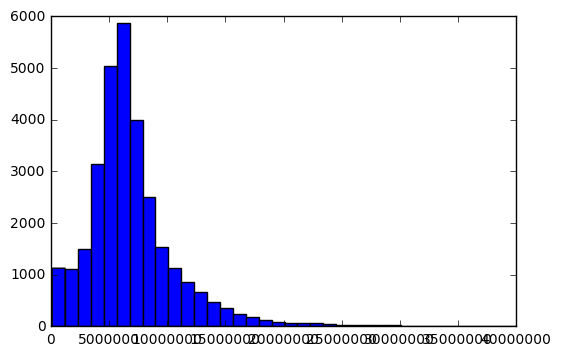

In [12]:
fig, ax = plt.subplots()

plt.figsize=(8, 16)
ax.ticklabel_format(useOffset=False, style='plain')
print ("Skew is:", df_train.price_doc.skew())

ax.hist(df_train.price_doc, bins=100, color='blue')
plt.xlim(0, 40000000)
plt.show()

The distribution of Prices is positively skewed, so we need to perform a Data Transformation on the target variable with a log transform.

__The goal is to increase the linear relationship between variables.__

We'll need to transform back to the original scale the predictions using the inverse of the transformation that was applied to the data.

Skew is: -0.686715679719


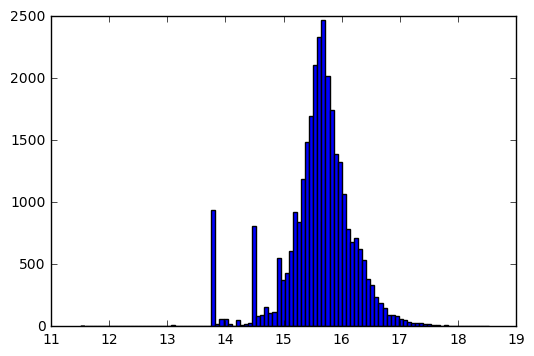

In [13]:
target = np.log(df_train.price_doc)
print ("Skew is:", target.skew())
plt.hist(target, bins=100, color='blue')
plt.show()

In [14]:
# Change Scientific Notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#df_train.price_doc.describe()
target = np.log(df_train.price_doc)
target.describe()

count   30471.000
mean       15.609
std         0.605
min        11.513
25%        15.372
50%        15.652
75%        15.932
max        18.526
Name: price_doc, dtype: float64

## Remove outliers in Price (Higher than 3 std)

In [591]:
print(df_train.shape)

df_train = df_train[np.abs(np.log(df_train.price_doc)-np.log(df_train.price_doc).mean())<=(3.0*np.log(df_train.price_doc).std())] 

print(df_train.shape)

(30471, 295)
(30325, 295)


## Examine Correlations between Features and the Target Variable.

In [592]:
numeric_features = df_train.select_dtypes(include=[np.number])

corr = numeric_features.corr()

print (corr['price_doc'].sort_values(ascending=False)[100:150], '\n')

cafe_count_1500_na_price      0.104
mosque_count_1000             0.103
cafe_count_2000               0.102
cafe_count_2000_price_1500    0.102
cafe_count_500                0.102
cafe_count_2000_price_500     0.101
cafe_count_2000_na_price      0.101
cafe_count_1000_price_1500    0.100
cafe_count_3000_price_4000    0.099
market_count_1500             0.098
cafe_count_1500_price_high    0.098
mosque_count_2000             0.097
cafe_count_2000_price_2500    0.096
trc_sqm_1500                  0.096
cafe_sum_1500_max_price_avg   0.096
cafe_count_1500_price_2500    0.095
cafe_avg_price_1500           0.095
cafe_count_1500               0.095
ID_railroad_terminal          0.094
mosque_count_3000             0.094
cafe_sum_2000_max_price_avg   0.094
cafe_sum_1500_min_price_avg   0.093
cafe_count_2000_price_high    0.093
cafe_avg_price_2000           0.092
cafe_count_1500_price_1500    0.092
state                         0.092
sport_count_500               0.090
cafe_count_1000_na_price    

## Select Features with a Correlation above 0.0

In [593]:
columns_corr = list(corr['price_doc'][corr['price_doc'] < 0.00].index)
#keep special features 
#columns_corr.remove("kitch_sq")
#floor max_floor kitch_sq full_sq

df_train = df_train.drop(columns_corr, axis = 1)
print(df_train.columns)
print(len(df_train.columns))

# Test File
df_test = df_test.drop(columns_corr, axis = 1)
print(df_test.columns)
print(len(df_test.columns))

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc', 'eurrub',
       'micex_cbi_tr'],
      dtype='object', length=211)
211
Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_4000', 'cafe_count_5000_price_high',
       'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
       'leisure_count_5000', 'sport_count_5000', 'market_count_5000', 'eurrub',
       'micex_cbi_tr'],
      dtype='object', length=210)
210


## Plot Correlation Between Price and Total Area

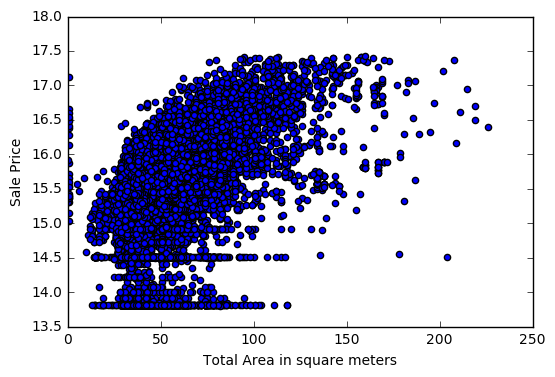

In [111]:
target = np.log(df_train.price_doc)
plt.scatter(x=df_train['full_sq'], y=target)
plt.xlim(0, 250)
plt.ylabel('Sale Price')
plt.xlabel('Total Area in square meters')
plt.show()

We can notice some Outliers, we need to remove them.

In [594]:
df_train = df_train[df_train['full_sq'] < 250]
df_train.shape

(30310, 211)

## Explore categorical columns

In [595]:
object_columns_df = df_train.select_dtypes(include=['object'])
object_columns_df.head(1)

,timestamp,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,2011-08-20,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good


In [596]:
# We need to skip the Date Column
filter_object_columns_df = list(object_columns_df.columns)[1:len(list(object_columns_df.columns))]
for column in filter_object_columns_df:
    print(df_train[column].value_counts())

Investment       19321
OwnerOccupier    10989
Name: product_type, dtype: int64
Poselenie Sosenskoe               1776
Nekrasovka                        1595
Poselenie Vnukovskoe              1372
Poselenie Moskovskij               925
Poselenie Voskresenskoe            713
Mitino                             678
Tverskoe                           670
Krjukovo                           516
Mar'ino                            507
Poselenie Filimonkovskoe           496
Juzhnoe Butovo                     451
Poselenie Shherbinka               443
Solncevo                           420
Zapadnoe Degunino                  410
Poselenie Desjonovskoe             362
Otradnoe                           352
Nagatinskij Zaton                  326
Nagornoe                           305
Bogorodskoe                        305
Strogino                           300
Izmajlovo                          300
Tekstil'shhiki                     297
Ljublino                           295
Gol'janovo              

### Select Top 50 Areas, and replace other areas with the label "Other". It will reduce the number of columns in the construction of Dummy Variables

less_frequent_area = object_columns_df.sub_area.value_counts()[50:].index

df_train.sub_area.replace(less_frequent_area, "Other", inplace=True)

## Remove "Poselenie Klenovskoe" which is not in test set 

print(df_train.shape)
df_train = df_train[df_train.sub_area != "Poselenie Klenovskoe"]
print(df_train.shape)

## Creation of Dummy Variables

In [597]:
# Remove sub Area with too many different values
filter_object_columns_df.remove("sub_area")
dummy_df = pd.get_dummies(df_train[filter_object_columns_df])
df_train = pd.concat([df_train, dummy_df], axis=1)
filter_object_columns_df.append("sub_area")
df_train = df_train.drop(filter_object_columns_df, axis=1)

##### Test File
object_columns_df = df_test.select_dtypes(include=['object'])
filter_object_columns_df = list(object_columns_df.columns)[1:len(list(object_columns_df.columns))]
# Remove sub Area with too many different values
filter_object_columns_df.remove("sub_area")
dummy_df_test = pd.get_dummies(df_test[filter_object_columns_df])
df_test = pd.concat([df_test, dummy_df_test], axis=1)
filter_object_columns_df.append("sub_area")
df_test = df_test.drop(filter_object_columns_df, axis=1)

# Feature Engineering 
## Add Count of Transactions for month_year and week_year

In [598]:
#Train
df_train["timestamp"] = pd.to_datetime(df_train["timestamp"])

month_year = (df_train.timestamp.dt.month + df_train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
#map month_year with value counts
df_train['month_year_count'] = month_year.map(month_year_cnt_map)

month_year = (df_train.timestamp.dt.weekofyear + df_train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_train['week_year_count'] = month_year.map(month_year_cnt_map)


#Test
df_test["timestamp"] = pd.to_datetime(df_test["timestamp"])

month_year = (df_test.timestamp.dt.month + df_test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_test['month_year_count'] = month_year.map(month_year_cnt_map)

month_year = (df_test.timestamp.dt.weekofyear + df_test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_test['week_year_count'] = month_year.map(month_year_cnt_map)

## Add month and day-of-week

In [599]:
#Train
df_train['month'] = df_train["timestamp"].dt.month
df_train['day'] = df_train["timestamp"].dt.dayofweek

#Test
df_test['month'] = df_test["timestamp"].dt.month
df_test['day'] = df_test["timestamp"].dt.dayofweek

## Other Feature Engineering

In [600]:
df_train['rel_floor'] = df_train['floor'] / df_train['max_floor'].astype(float)
df_train['rel_kitch_sq'] = df_train['kitch_sq'] / df_train['full_sq'].astype(float)

df_test['rel_floor'] = df_test['floor'] / df_test['max_floor'].astype(float)
df_test['rel_kitch_sq'] = df_test['kitch_sq'] / df_test['full_sq'].astype(float)

### Check if there is no Null Values.

In [601]:
print(sum(df_train.isnull().sum() != 0))
print(sum(df_test.isnull().sum() != 0))

2
1


### Replace by 0 when we divide by 0

In [602]:
df_train["rel_floor"].fillna(0, inplace=True)
df_train["rel_kitch_sq"].fillna(0, inplace=True)

df_test["rel_floor"].fillna(0, inplace=True)
df_test["rel_kitch_sq"].fillna(0, inplace=True)

print(sum(df_train.isnull().sum() != 0))
print(sum(df_test.isnull().sum() != 0))

0
0


In [299]:
df_train.to_csv('./final_train.csv', index=False)
df_test.to_csv('./final_test.csv', index=False)

# 4) Making Predictions

In [463]:
df_train = pd.read_csv('./final_train.csv')
df_test = pd.read_csv('./final_test.csv')

# TRAINING XGBoost
## Split Features and Target 

In [603]:
X = df_train.drop(['price_doc', 'timestamp', 'id'], axis=1)
Y = np.log(df_train.price_doc)

In [31]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt

/Users/comalada/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/comalada/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Split Train and Test (80/20)

In [604]:
from sklearn.model_selection import train_test_split
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, random_state=42, test_size=.20)

## Cross Validation : Model Tuning

In [605]:
params_tuning = {
    'max_depth': [6],
    'min_child_weight': [5],
    'colsample_bytree': [0.8],
    'subsample': [0.7, 0.8],
    'learning_rate': [0.07]
}

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 5,
    #'subsample': 0.7,
    #'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'n_estimators': 100
        }

In [606]:
gridsearch_xgb = GridSearchCV(xgb.XGBRegressor(xgb_params), params_tuning, cv = 3) 
gridsearch_xgb.fit(X, Y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'eta': 0.05, 'silent': 1, 'min_child_weight': 5, 'n_estimators': 100, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'max_depth': 6},
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.07], 'subsample': [0.7, 0.8], 'min_child_weight': [5], 'colsample_bytree': [0.8], 'max_depth': [6]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [607]:
gridsearch_xgb.grid_scores_

[mean: 0.36263, std: 0.04935, params: {'subsample': 0.7, 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.07, 'colsample_bytree': 0.8},
 mean: 0.36345, std: 0.04780, params: {'subsample': 0.8, 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.07, 'colsample_bytree': 0.8}]

In [608]:
gridsearch_xgb.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.07,
 'max_depth': 6,
 'min_child_weight': 5,
 'subsample': 0.8}

In [609]:
gridsearch_xgb.best_score_

0.3634474830780685

In [610]:
y_predicted = gridsearch_xgb.best_estimator_.predict(X_validation)

In [611]:
RMSE = sqrt(mean_squared_error(Y_validation, y_predicted))
print(RMSE)

0.41184794670916325


Best Score : 0.40898454506531656

## Boost Iteration

In [612]:
df_columns = X.columns
dfinal = xgb.DMatrix(X, Y, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, Y_train, feature_names=df_columns)
dvalidation = xgb.DMatrix(X_validation, Y_validation, feature_names=df_columns)

In [613]:
xgb_params = {
    'eta': 0.07,
    'max_depth': 6,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [614]:
model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
                   evals=[(dvalidation, 'validation')], verbose_eval=10)

[0]	validation-rmse:14.0581
Will train until validation-rmse hasn't improved in 20 rounds.
[10]	validation-rmse:6.81773
[20]	validation-rmse:3.3258
[30]	validation-rmse:1.6609
[40]	validation-rmse:0.898867
[50]	validation-rmse:0.588626
[60]	validation-rmse:0.487707
[70]	validation-rmse:0.459179
[80]	validation-rmse:0.451354
[90]	validation-rmse:0.448678
[100]	validation-rmse:0.448025
[110]	validation-rmse:0.447272
[120]	validation-rmse:0.447455
[130]	validation-rmse:0.446794
[140]	validation-rmse:0.44651
[150]	validation-rmse:0.446463
[160]	validation-rmse:0.446241
[170]	validation-rmse:0.446155
[180]	validation-rmse:0.44628
[190]	validation-rmse:0.446415
Stopping. Best iteration:
[175]	validation-rmse:0.446081



In [615]:
num_boost_round = model_xgb.best_iteration

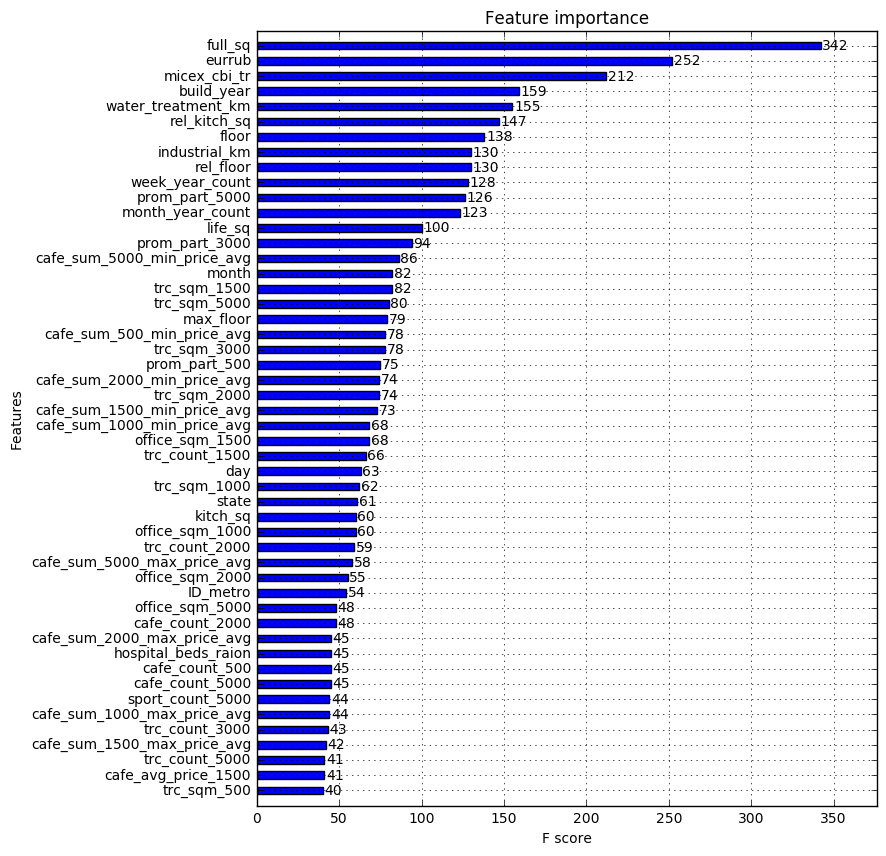

In [616]:
#watchlist = [(dtrain, 'train'), (dvalidation, 'eval')]


final_model_xgb = xgb.train(xgb_params, dfinal, num_boost_round = num_boost_round)


fig, ax = plt.subplots(1, 1, figsize=(8, 10))
xgb.plot_importance(model_xgb, max_num_features=50, height=0.5, ax = ax)

## Examine if there there is Overfitting 

In [617]:
#Validation Set
y_predicted = final_model_xgb.predict(dvalidation)
RMSE = sqrt(mean_squared_error(Y_validation, y_predicted))
print(RMSE)

0.3861757706757739


In [618]:
#Train Set
y_predicted = final_model_xgb.predict(dtrain)
RMSE = sqrt(mean_squared_error(Y_train, y_predicted))
print(RMSE)

0.3885510253860355


 # Submission File

In [619]:
#Get the Id for the submission file
id_test = df_test.id

df_test = df_test.drop(['timestamp','id'], axis=1)
dtest = xgb.DMatrix(df_test)

Y_pred = final_model_xgb.predict(dtest)

#Transform the Prediction to the correct form : we reverse Log() with Exp() 
final_predictions = np.exp(Y_pred)

print ("Original predictions are: \n", Y_pred[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

df_submission = pd.DataFrame({'id': id_test, 'price_doc': final_predictions})
df_submission.to_csv('submission.csv', index=False)

Original predictions are: 
 [ 15.50947571  15.96798325  15.51424122  15.60823727  15.48534298] 

Final predictions are: 
 [ 5441012.5  8606112.   5467003.5  6005806.   5311277.5]
